# **Final Project: Practicing Convolutional Neural Network**
# CIFAR 10 challenge 
In this problem, we will build models to classifier with deep neural nets.

In [1]:
!pip install -q plaidml-keras
import keras

!pip3 install torch torchvision
!pip install livelossplot

     |████████████████████████████████| 317kB 5.1MB/s 
     |████████████████████████████████| 32.1MB 1.4MB/s 


Using TensorFlow backend.


In [0]:
import plaidml.keras
plaidml.keras.install_backend()

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D
from keras.utils import print_summary, to_categorical
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import optimizers

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

Get the permission to access google drive for dataset retrieval


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**1. Data loading and data preprocessing**

This data set contains five data batches for training, one data set for testing and one meta file contains label names. 

**unpicke:**
Each of the files is a Python "pickled" object produced with cPickle. Here is a routine which will open such a file and return a dictionary Please be noted, encoding should be 'latin1'.

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict


**normalize:**
Normalize the input image data which is in the format of numpy array

In [0]:
def normalize(val):
  min_val = np.min(val)
  max_val = np.max(val)
  val = (val - min_val) /(max_val - min_val)
  return val

**load cfar10:**
Each of the batch files contains a dictionary with the following elements:

"data" -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 is the green, and the final 1024 is the blue.

"labels" -- a list of 10000 numbers in the range of 0-9. The number at index i indicates the label of the ith image in the array data.

link: https://www.cs.toronto.edu/~kriz/cifar.html

Convert the input tensor to be (width x height x num_channel)


In [0]:
def load_batch(cifar10_dataset_path, batch_num):
  import pickle
  with open(cifar10_dataset_path + '/data_batch_' + str(batch_num), mode='rb') as file:
      batch = pickle.load(file, encoding = 'latin1')
      print('load batch' + str(batch_num))
  features = batch['data'].reshape(len(batch['data']), 3, 32, 32).transpose(0, 2, 3, 1)
  labels = batch['labels']
  return features, labels

Loading data (metaDict, testDict, trainingSet).

For categorical columns, do one-hot encoding.

In [7]:
cifar10_dir = '/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py'
metaDict = unpickle('/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py/batches.meta')
# meta file
label_names = metaDict['label_names']

# testing set
testDict = unpickle('/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py/test_batch')
x_test = testDict['data'].reshape(len(testDict['data']),3, 32, 32).transpose(0, 2, 3, 1)
y_test = testDict['labels']
x_test = normalize(x_test)
y_test = to_categorical(y_test)

# training set
# x_trainging is feature, y_training is label from load_batch function
x_trainingList = list()
y_trainingList = list()
for i in range(1, 6):
  x_training = []
  y_training = []
  (x_training, y_training) = load_batch(cifar10_dir, i)
  x_training = normalize(x_training)
  y_training = to_categorical(y_training)
  x_trainingList.append(x_training)
  y_trainingList.append(y_training)

load batch1
load batch2
load batch3
load batch4
load batch5


The training and testing data look like this.

In [8]:
print('Trainig features are:\n', x_trainingList[1][0])
print('Training labels are:\n', y_trainingList[1][0])

Trainig features are:
 [[[0.1372549  0.09803922 0.10196078]
  [0.10588235 0.08235294 0.08235294]
  [0.09803922 0.07843137 0.0745098 ]
  ...
  [0.51764706 0.50588235 0.50588235]
  [0.52156863 0.4745098  0.45490196]
  [0.49411765 0.45098039 0.44313725]]

 [[0.24705882 0.21568627 0.19607843]
  [0.1254902  0.10588235 0.08235294]
  [0.06666667 0.05098039 0.03137255]
  ...
  [0.4        0.37254902 0.34509804]
  [0.41176471 0.34901961 0.29803922]
  [0.39215686 0.3372549  0.30196078]]

 [[0.38823529 0.35686275 0.32941176]
  [0.19215686 0.17647059 0.14509804]
  [0.05882353 0.04705882 0.01960784]
  ...
  [0.18039216 0.16862745 0.15294118]
  [0.20392157 0.16078431 0.13333333]
  [0.20392157 0.17254902 0.16078431]]

 ...

 [[0.65098039 0.64705882 0.67058824]
  [0.64313725 0.63921569 0.65098039]
  [0.64313725 0.64313725 0.64705882]
  ...
  [0.67843137 0.6745098  0.66666667]
  [0.66666667 0.66666667 0.65882353]
  [0.65490196 0.65490196 0.65490196]]

 [[0.6627451  0.65882353 0.69019608]
  [0.6627451  

**2. Model training: an image classification problem**

1.Create the model architecture.

We use the Sequential model to create a CNN model repeating a few layers of a convolution layer followed by a pooling layer then a dropout layer.


In [9]:
classes_num = 10
input_shape = (32, 32, 3)
weight_decay =  0.0005

model = Sequential()

# first CONV => RELU => CONV => RELU => POOL layer => dropout
model.add(Conv2D(32, (3, 3), padding = 'same',  kernel_regularizer=l2(weight_decay), input_shape = input_shape)) 
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding = 'same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set => dropout
model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding = 'same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))  

# third CONV => RELU => CONV => RELU => POOL layer set => dropout
model.add(Conv2D(128, (3, 3), padding = 'same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(128, (5, 5), padding = 'same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))  


# set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))

# softmax classifier
model.add(Dense(classes_num))
model.add(Activation('softmax'))








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2.Compile the model

We use model.compile() to configure the learning process. This is to define the type of loss function, optimizer and the metrics.

In [10]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
________

3.Train the model

We will train the model with a batch_size of 32, 25 epochs.

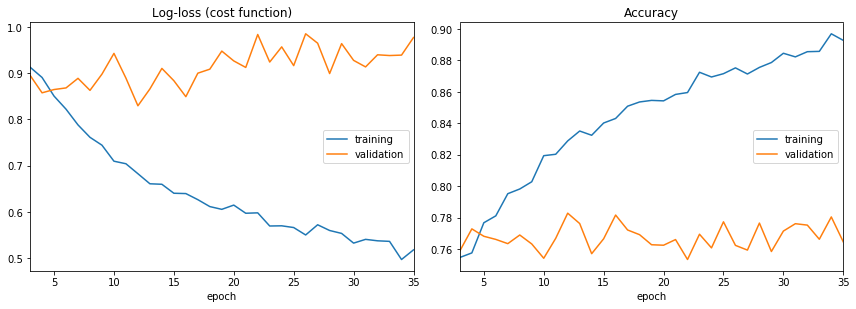

Log-loss (cost function):
training   (min:    0.497, max:    1.124, cur:    0.518)
validation (min:    0.829, max:    0.985, cur:    0.977)

Accuracy:
training   (min:    0.693, max:    0.897, cur:    0.893)
validation (min:    0.738, max:    0.783, cur:    0.764)
Saved model to disk for batch:4
10000/10000 [==============================] - 1s 148us/step
[1.0205413023948668, 0.7638]


In [12]:
batch_size = 64
epochs = 35
valBatch = 0

from livelossplot.keras import PlotLossesCallback

for i in range(1, 5):
		history = model.fit(x_trainingList[i], y_trainingList[i],
						batch_size = batch_size,
						epochs= epochs,
						validation_data=(x_trainingList[valBatch], y_trainingList[valBatch]),
						callbacks=[PlotLossesCallback()],
						verbose=2,
						shuffle = True)
model.save('my_model1.h5', overwrite=True)
print("Saved model to disk for batch:" + str(i))
model = load_model('my_model1.h5')
print(model.evaluate(x = x_test, y = y_test))

Results:
Validation dataset: log-loss is 0.9522, accuracy is 0.7875

testing dataset: log-loss is 0.980, accuracy is 0.7838


4.Test Accuracy

We use the model to classify the test set.
We create a confusion matrix and a classification report.

In [0]:
def get_class_from_softmax(list):
  max_value = 0.0
  max_index = 0
  for i in range(len(list)):
    if list[i] > max_value:
      max_value = list[i]
      max_index = i
  return max_index

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

#y_pred is the prediction
y_pred_label = list()
y_label = list()
y_label_class = list()
y_pred_class = list()
y_pred = model.predict(x_test)

for i in range(len(y_pred)):
  y_label.append(label_names[get_class_from_softmax(y_test[i])])
  y_pred_label.append(label_names[get_class_from_softmax(y_pred[i])])
  y_pred_class.append(get_class_from_softmax(y_pred[i]))
  y_label_class.append(get_class_from_softmax(y_test[i]))

print('Confusion Matrix')
confusion_matrix = confusion_matrix(y_label, y_pred_label, labels = label_names)
print(pd.DataFrame(confusion_matrix, index=label_names, columns=label_names))
print('Classification Report')
print(classification_report(y_label_class, y_pred_class, target_names= label_names))

Confusion Matrix
            airplane  automobile  bird  cat  ...  frog  horse  ship  truck
airplane         804          21    34   16  ...    15     21    30     38
automobile         9         870     3    4  ...    18      2    10     81
bird              72           2   559   33  ...   137     31     2      9
cat               15           6    44  568  ...   131     43     2     18
deer              11           0    27   49  ...    85     57     2      7
dog                6           3    26  140  ...    60     65     1      2
frog               3           2    11   25  ...   920      4     3      1
horse              9           3    16   32  ...    21    846     0      9
ship              73          32     9   10  ...    23      7   807     32
truck             20          52     4    6  ...    16      8     9    878

[10 rows x 10 columns]
Classification Report
              precision    recall  f1-score   support

    airplane       0.79      0.80      0.80      1000
  a